# Spectroscopy: CCD Characterisation and master bias/flat

`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 26 Jul 2022

Adapted from HAP703P

Reference: *Handbook of CCD Astronomy*, §4.3
* compute CCD gain and readout noise
* compute and save master bias
* compute and save master flat

In [1]:
# import and settings
%matplotlib notebook
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import mad_std
from astropy import units as u
from astropy.visualization import ZScaleInterval
import ccdproc as ccdp
from iraf_um import imstat, inv_median

In [2]:
# create bias image collections and print summary
print("Bias frames")
ifc_bias = ccdp.ImageFileCollection('calibration/', glob_include='Bias_*.fit*')
print(ifc_bias.summary['date', 'exposure'], '\n')
# load bias CCDData objects and reshape data to be 2-D images
# using an ImageFileCollection does not work because of the data shape (naxis=3)
ccdd_bias = [ccdp.CCDData.read(ifc_bias.location+bias_file, unit='adu') for bias_file in ifc_bias.files]
print("original bias shape:", ccdd_bias[0].data.shape)
for b in ccdd_bias:
    b.data = b.data[0]
print("new bias shape:", ccdd_bias[0].data.shape)
print("")

# same operations for flat fields
print("Flat Field frames")
ifc_flat = ccdp.ImageFileCollection('calibration/', glob_include='Flat_*.fit*')
print(ifc_flat.summary['date', 'exposure'])
#
ccdd_flat = [ccdp.CCDData.read(ifc_flat.location+flat_file, unit='adu') for flat_file in ifc_flat.files]
print("original flat shape:", ccdd_flat[0].data.shape)
for f in ccdd_flat:
    f.data = f.data[0]
print("new flat shape:", ccdd_flat[0].data.shape)


Bias frames
        date        exposure
------------------- --------
2022-09-19T19:47:40    1e-05
2022-09-19T19:47:58    1e-05
2022-09-19T19:48:04    1e-05
2022-09-19T19:48:10    1e-05
2022-09-19T19:48:15    1e-05
2022-09-19T19:48:21    1e-05
2022-09-19T19:48:26    1e-05
2022-09-19T19:48:33    1e-05
2022-09-19T19:48:39    1e-05
2022-09-19T19:48:44    1e-05
                ...      ...
2022-09-22T18:45:11    1e-05
2022-09-21T18:41:55    1e-05
2022-09-21T18:42:06    1e-05
2022-09-21T18:42:16    1e-05
2022-09-21T18:42:22    1e-05
2022-09-21T18:42:36    1e-05
2022-09-21T18:42:42    1e-05
2022-09-21T18:42:47    1e-05
2022-09-21T18:42:53    1e-05
2022-09-21T18:42:58    1e-05
2022-09-21T18:43:03    1e-05
Length = 32 rows 

original bias shape: (1, 100, 2048)
new bias shape: (100, 2048)

Flat Field frames
        date        exposure
------------------- --------
2022-09-21T18:32:54     30.0
2022-09-21T18:33:58     30.0
2022-09-21T18:34:35     30.0
2022-09-21T18:35:12     30.0
2022-09-21T18:35

## CCD gain and readout noise

In [3]:
# compute and display statistics on two bias and two flat field frames
imstat(['bias1', 'bias2', 'flat1', 'flat2'], [ccdd_bias[0], ccdd_bias[1], ccdd_flat[2], ccdd_flat[3]])

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   bias1    204800  287.000   314.000 ...  301.000    2.931    2.965  adu
   bias2    204800  288.000   315.000 ...  302.000    2.918    2.965  adu
   flat1    204800  300.000 13448.000 ...  315.000 3226.686 2109.743  adu
   flat2    204800  297.000 13561.000 ...  313.000 3229.426 2112.708  adu


<IPython.core.display.Javascript object>


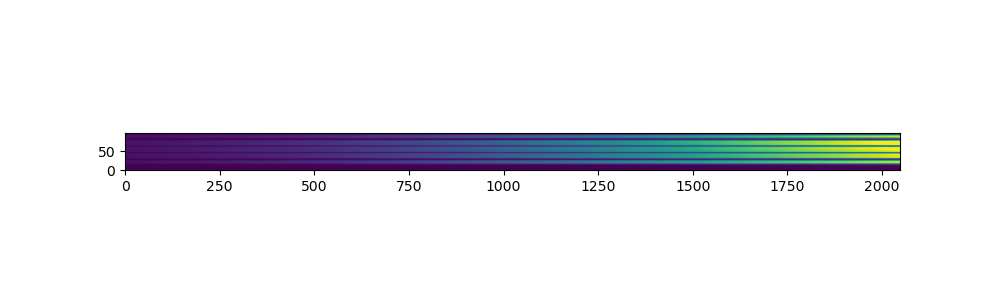

In [4]:
# Plot flat-field frames to identify illuminated area
plt.figure(figsize=(10,3))
interval = ZScaleInterval()
z1, z2 = interval.get_limits(ccdd_flat[0])
plt.imshow(ccdd_flat[0].data, origin='lower', vmin=z1, vmax=z2)
plt.show()

In [5]:
#Interpolation meilleure couple de flat

for i in range(8):
    for j in range(i):
        #Check histogram, flat + ThAr ???
        print('\nCouple',i,' and ',j)
        sumb1b2 = ccdd_bias[i].data.astype('float32') + ccdd_bias[j].data.astype('float32')
        diffb1b2 = ccdd_bias[i].data.astype('float32') - ccdd_bias[j].data.astype('float32')
        sumf1f2 = ccdd_flat[i].data.astype('float32') + ccdd_flat[j].data.astype('float32')
        difff1f2 = ccdd_flat[i].data.astype('float32') - ccdd_flat[j].data.astype('float32')
        
        imstat(['b1+b2', 'b1-b2', 'f1+f2', 'f1-f2'], [sumb1b2, diffb1b2, sumf1f2, difff1f2])
        
        ccd_gain = (np.mean(sumf1f2) - np.mean(sumb1b2)) / (np.var(difff1f2) - np.var(diffb1b2)) * u.electron / u.adu
        print('CCD Gain = ', ccd_gain)
        ccd_ron = ccd_gain * np.std(diffb1b2) / np.sqrt(2.) * u.adu
        print('CCD RON = ', ccd_ron)


Couple 1  and  0
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  582.000   620.000 ...  598.000    4.142    4.448 None
   b1-b2    204800  -20.000    19.000 ...    0.000    4.130    4.448 None
   f1+f2    204800  606.000 26882.000 ...  622.000 6449.554 4219.486 None
   f1-f2    204800 -566.000   614.000 ...   14.000   77.975   45.961 None
CCD Gain =  0.9585719108581543 electron / adu
CCD RON =  2.799674544692058 electron

Couple 2  and  0
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  581.000   621.000 ...  599.000    4.159    4.448 None
   b1-b2    204800  -18.000    21.000 ...   -1.000    4.134    4.448 None
   f1+f2    204800  606.000 26714.000 ...  627.000 6452.092 4220.969 None
   f1-f2    204800 -700.000   576.000 ...    9.000   77.757   45.9

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  584.000   622.000 ...  600.000    4.152    4.448 None
   b1-b2    204800  -18.000    19.000 ...   -2.000    4.141    4.448 None
   f1+f2    204800  605.000 26888.000 ... 1764.000 6461.048 4226.899 None
   f1-f2    204800 -558.000   595.000 ...   -2.000   80.529   47.443 None
CCD Gain =  0.9000292420387268 electron / adu
CCD RON =  2.6354269273459514 electron

Couple 6  and  1
frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  582.000   620.000 ...  602.000    4.138    4.448 None
   b1-b2    204800  -18.000    19.000 ...   -4.000    4.138    4.448 None
   f1+f2    204800  606.000 26765.000 ...  618.000 6459.334 4223.192 None
   f1-f2    204800 -503.000   653.000 ...   -2.000   79.810   45.961 None
CCD Gain 

In [6]:
# Compute sums and differences of bias abd flat frames and print statistics
sumb1b2 = ccdd_bias[0].data.astype('float32') + ccdd_bias[1].data.astype('float32')
diffb1b2 = ccdd_bias[0].data.astype('float32') - ccdd_bias[1].data.astype('float32')
sumf1f2 = ccdd_flat[4].data.astype('float32') + ccdd_flat[3].data.astype('float32')
difff1f2 = ccdd_flat[4].data.astype('float32') - ccdd_flat[3].data.astype('float32')
imstat(['b1+b2', 'b1-b2', 'f1+f2', 'f1-f2'], [sumb1b2, diffb1b2, sumf1f2, difff1f2])

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   b1+b2    204800  582.000   620.000 ...  598.000    4.142    4.448 None
   b1-b2    204800  -19.000    20.000 ...    0.000    4.130    4.448 None
   f1+f2    204800  603.000 26801.000 ...  625.000 6460.862 4225.416 None
   f1-f2    204800 -566.000   574.000 ...    7.000   77.758   45.961 None


In [7]:
# Compute gain and readout noise
ccd_gain = (np.mean(sumf1f2) - np.mean(sumb1b2)) / (np.var(difff1f2) - np.var(diffb1b2)) * u.electron / u.adu
print('CCD Gain = ', ccd_gain)
ccd_ron = ccd_gain * np.std(diffb1b2) / np.sqrt(2.) * u.adu
print('CCD RON = ', ccd_ron)

CCD Gain =  0.965720534324646 electron / adu
CCD RON =  2.8205532505073845 electron


À comparer aux spécifications données sur l'espace moodle HAP905P : __[https://moodle.umontpellier.fr/mod/book/view.php?id=5461&chapterid=234](https://moodle.umontpellier.fr/mod/book/view.php?id=5461&chapterid=234)__

## Master bias

In [8]:
# compute master bias
master_bias = ccdp.combine(ccdd_bias, unit='adu', combine='average', 
    sigma_clip=True, sigma_clip_low_thresh=7., sigma_clip_high_thresh=7., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
    mem_limit=512.e6)

In [9]:
# set header keyword (will appear in the saved file)
master_bias.meta['COMBINED'] = True

In [10]:
# compare statiscal properties of the series and the master frame
imstat(ifc_bias.files, ccdd_bias)
print('\n')
imstat('master bias', master_bias)

                   frame id                       npix   ...   mad    unit
---------------------------------------------- --------- ... -------- ----
Bias_M2_ML_Mon Sep 19 2022_19.47.45_00001.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.03_00002.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.09_00003.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.15_00004.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.20_00005.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.25_00006.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.31_00007.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.38_00008.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.44_00009.fits    204800 ...    2.965  adu
Bias_M2_ML_Mon Sep 19 2022_19.48.49_00010.fits    204800 ...    2.965  adu
                                           ...       ... ...      ...  ...
Bias_M2_ML_Thu Sep 22 202

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


<IPython.core.display.Javascript object>


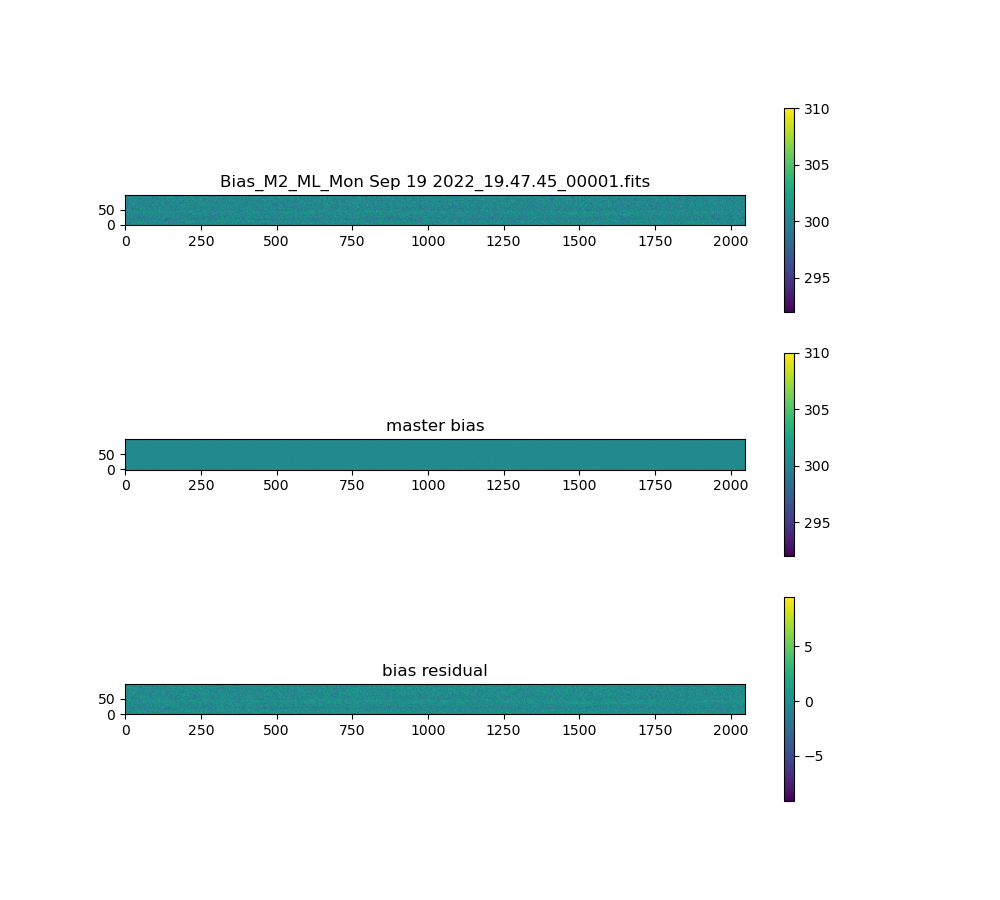

In [11]:
# display 1st bias, master bias and residual
fig = plt.figure(figsize=(10,9))
#
ax1 = fig.add_subplot(311)
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(ccdd_bias[0])
im1 = ax1.imshow(ccdd_bias[0].data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im1)
ax1.set_title(ifc_bias.files[0])
#
ax2 = fig.add_subplot(312)
im2 = ax2.imshow(master_bias.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im2)
ax2.set_title('master bias')
#
ax3 = fig.add_subplot(313)
res_bias = ccdd_bias[0].data - master_bias.data
interval2 = ZScaleInterval()
z1, z2 = interval2.get_limits(res_bias)
im3 = ax3.imshow(res_bias, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im3)
ax3.set_title('bias residual')
plt.show()

In [12]:
# once master bias is fine-tuned save it
master_bias.write('reference/master_bias.fits', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

## Master Flat

In [13]:
# bias subtract the flat-field images and save them in the tmp directory
for ccd, fname in zip(ccdd_flat, ifc_flat.files):
    ccd = ccdp.subtract_bias(ccd, master_bias)
    fname_tmp = os.path.splitext(fname)[0] + '_b' + os.path.splitext(fname)[1]
    ccd.write('tmp' +'/' + fname_tmp)

In [14]:
# check statistics of bias-subtracted files
imstat(ifc_flat.files, ccdd_flat)
print('\n')
ifc_flat_b = ccdp.ImageFileCollection('tmp/', glob_include='Flat_*.fit*')
# the bias-corrected flat fields have the right shape (naxis=2) by construction
print(ifc_flat_b.location+ifc_flat_b.files[0], " shape: ", ccdp.CCDData.read(ifc_flat_b.location+ifc_flat_b.files[0]).data.shape, "\n")
#imstat(ifc_flat_b.files, ifc_flat_b.data())
# create a CCDData list to exclude the two flats w/ differents stats
ccdd_flat_b = [ccdp.CCDData.read(ifc_flat_b.location+flat_file) for flat_file in ifc_flat_b.files][2:]
fname_flat_b = ifc_flat_b.files[2:]
#imstat(fname_flat_b, ccdd_flat_b)

                   frame id                       npix   ...   mad    unit
---------------------------------------------- --------- ... -------- ----
Flat_M2_ML_Wed Sep 21 2022_18.33.28_00000.fits    204800 ... 2109.743  adu
Flat_M2_ML_Wed Sep 21 2022_18.34.33_00001.fits    204800 ... 2109.743  adu
Flat_M2_ML_Wed Sep 21 2022_18.35.10_00002.fits    204800 ... 2109.743  adu
Flat_M2_ML_Wed Sep 21 2022_18.35.47_00003.fits    204800 ... 2112.708  adu
Flat_M2_ML_Wed Sep 21 2022_18.36.28_00004.fits    204800 ... 2114.191  adu
Flat_M2_ML_Wed Sep 21 2022_18.37.04_00005.fits    204800 ... 2114.191  adu
Flat_M2_ML_Wed Sep 21 2022_18.37.47_00006.fits    204800 ... 2115.673  adu
Flat_M2_ML_Wed Sep 21 2022_18.38.42_00007.fits    204800 ... 2115.673  adu


tmp/Flat_M2_ML_Wed Sep 21 2022_18.33.28_00000_b.fits  shape:  (100, 2048) 



In [15]:
# compute master flat with scaling/normalisation excluding the two flats w/ different stats
master_flat = ccdp.combine(ccdd_flat_b, unit='adu', method='average', scale=inv_median, gain=ccd_gain, readnoise=ccd_ron, sigma_clip=True, sigma_clip_low_thresh=5., sigma_clip_high_thresh=5., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, mem_limit=512.e6)

In [16]:
# set header keyword (will appear in the saved file)
master_flat.meta['COMBINED'] = True

In [17]:
# print statiscal properties of master frame
imstat('master flat', master_flat)

  frame id     npix     min      max    ...   mode     std      mad    unit
----------- --------- -------- -------- ... -------- -------- -------- ----
master flat    204800    0.003    8.539 ...    0.005    2.112    1.382  adu


/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


<IPython.core.display.Javascript object>


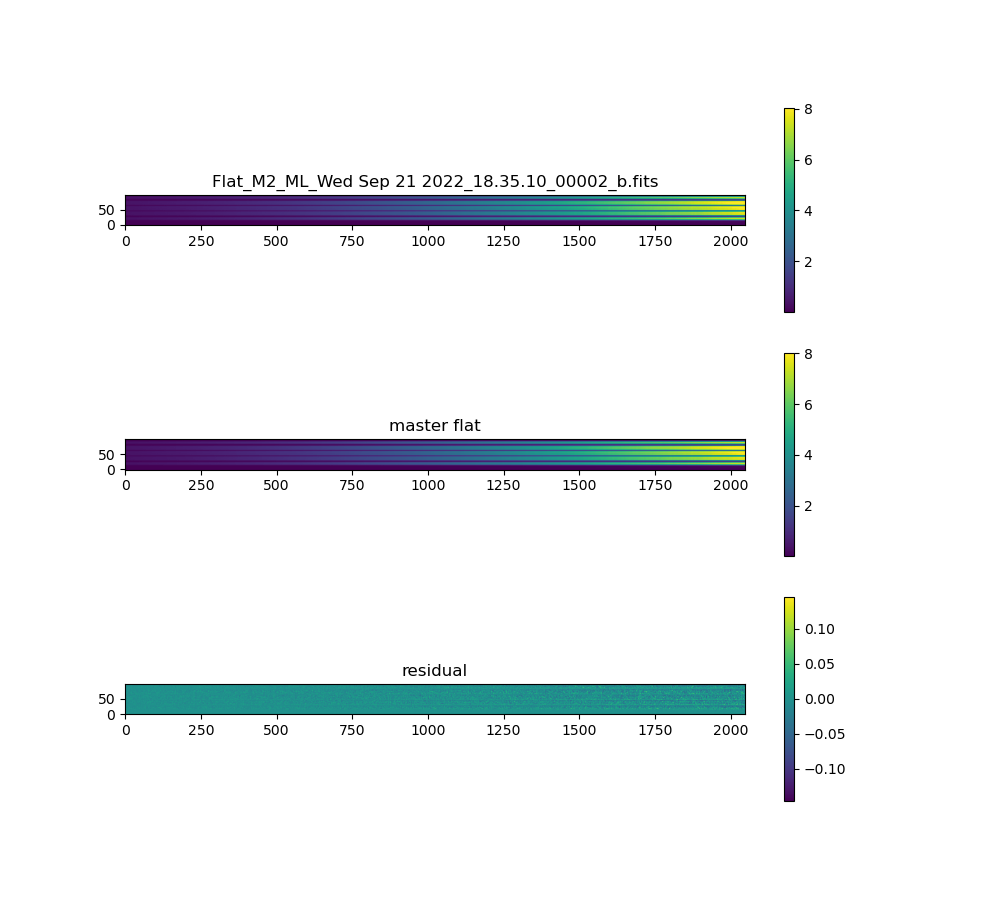

In [18]:
# display 1st scaled flat, master flat and residual
fig = plt.figure(figsize=(10,9))
#
ax1 = fig.add_subplot(311)
ccd_flat1_n = ccdd_flat_b[0] / np.median(ccdd_flat_b[0].data)
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(ccd_flat1_n)
im1 = ax1.imshow(ccd_flat1_n.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im1)
ax1.set_title(fname_flat_b[0])
#
ax2 = fig.add_subplot(312)
im2 = ax2.imshow(master_flat.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im2)
ax2.set_title('master flat')
#
ax3 = fig.add_subplot(313)
res_flat = ccd_flat1_n.data - master_flat.data
interval2 = ZScaleInterval()
z1, z2 = interval2.get_limits(res_flat)
im3 = ax3.imshow(res_flat, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im3)
ax3.set_title('residual')
plt.show()

In [19]:
# print statistics of the residual image
imstat('flat residual', res_flat, fmt='.3e')

   frame id      npix      min        max    ...    std       mad    unit
------------- --------- ---------- --------- ... --------- --------- ----
flat residual    204800 -2.861e-01 2.695e-01 ... 3.354e-02 1.912e-02 None


In [20]:
# save master flat
master_flat.write('reference/master_flat.fits', overwrite=True)

## Clean temporary files

In [21]:
# remove all FITS files from the tmp directory
fileList = glob.glob('tmp/*.fit*')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

In [22]:
"""
Rejet du flat 8 et 9
"""

'\nRejet du flat 8 et 9\n'